# Urban Sound Classification - Part 1

It's been a while since my last post. So far I've been mainly writing about NLP, but I should admit that my focus was quite narrow. Out of 19 posts I have written so far, 13 of them were about NLP, and more specifically sentiment analysis. Even though it encompasses a lot of side tasks to get to the goal of sentiment classifier, but still the end goal is sentiment analysis. Of course, I'm still nowhere near an expert, and still have a lot more to learn than I already learned, but to give my data science learning a bit of diversity, I turned to another type of data.

## Audio data

Before I try anything, the first thing I wanted to do was get to know this new friend better. What is sound? To have a basic understanding of the data that I'll be dealing with, I'll have to go to a fundamental level.

The sound is compressions and rarefactions in the air that an ear will pick up. The sound is a movement of air. Often expressed in a waveform, which shows what's happening to air particles, moving back and forth over time. The vertical axis shows how the air is moving either backwards or forwards with respect to a zero position. The horizontal axis shows time.

The above explanation is taken from a Youtube video
https://youtu.be/yWqrx08UeUs
He did a really good job explaining sound, sampling, Nyquist Theorem. But wait, the waveform of a sound looks like it's moving up and down, but he's saying it's moving back and forth. What am I missing? To be honest, I spent quite some time here to get my head around. It might be elementary Physics, but I didn't pay much attention to Physics classes during my school years. I never imagined this will come back to haunt me.

From here, it will be a bit of review of introductory Physics, so if you are already familiar with it, you might find the content of this post a bit too basic.

We often hear a term "sound wave", yes the sound is a wave. Then what is "wave"? Waves are vibrations that transfer energy from place to place without the matter being transferred. Depending on different characteristics of waves, there exist different categories of waves. Here I will talk about two of them: transverse waves and longitudinal waves.

![title](urbansound_image/longitudinal-wave-vs-transverse-wave.jpg)

A transverse wave is a wave in which the particles of the medium are displaced in a direction perpendicular to the direction of energy transport. You can think of a stretched rope sending waves by moving up and down on the one end. A longitudinal wave is a wave in which the particles of the medium are displaced in a direction parallel to the direction of energy transport. As you can imagine from the above picture, one example is slinky. With stretched out slinky (one end fixed), if you hold the other end of the slinky and move slinky back and forth, this will transfer a wave looks similar to the above picture on the left.

An example of a transverse wave is water, and an example of a longitudinal wave is sound.
Then I was confused. OK, I now understand sound is the longitudinal wave, but why am I seeing all the sound plots looking like transverse waves?

![title](urbansound_image/AC.png)

You might have seen plots looking like above. In the above plot, A, C is pitch, and 440HZ, 535.25HZ are their frequencies. After a lot of Googling, I finally got it. By the way, sorry if this is too elementary for you. But for me, it was one of those Eureka moments.

"An incorrect understanding of this graph would be to picture air molecules going up and down as they travel across space from the place in which the sound originates to the place in which it is heard. This would be as if a particular molecule starts out where the sound originates and ends up in the listener’s ear. This is not what is being pictured in a graph of a sound wave. It is the energy, not the air molecules themselves, that is being transmitted from the source of a sound to the listener’s ear."http://digitalsoundandmusic.com/chapters/ch2/

When we hear a sound, we don't get air molecules hitting our ears like a wind. We just hear a sound, that is because air is medium that transports the energy (sound), and the medium itself is not being transferred. So, the waves we see from sound wave plot is not plotting up and down movement of air, but it's plotting compression and rarefaction of air particles. What looks like a crest in sound wave plot is actually a compression where air molecules are close together, and what looks like a trough is actually a rarefaction, where air molecules are more spread out. And following the same logic, what looks like equilibrium (0 on the y-axis) is the ambient pressure present before sound was produced.

## Dataset: UrbanSound8K

With the basic understanding of sound and sound wave plot, we can take a peek at our dataset.

You can find more information about how the classes are drawn and data is collected, but to give you a short overview of data, "this dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music"
https://serv.cusp.nyu.edu/projects/urbansounddataset/urbansound8k.html

According to the original paper, sound excerpts are taken from www.freesound.org and are already pre-sorted into ten folds for cross-validation.

Let's first take a look at the meta-data.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")

In [2]:
data.shape

(8732, 8)

In [3]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


The meta-data contains 8 columns.

- slice_file_name: name of the audio file
- fsID: FreesoundID of the recording where the excerpt is taken from
- start: start time of the slice
- end: end time of the slice
- salience: salience rating of the sound. 1 = foreground, 2 = background
- fold: The fold number (1-10) to which this file has been allocated
- classID:<br>
0 = air_conditioner<br>
1 = car_horn<br>
2 = children_playing<br>
3 = dog_bark<br>
4 = drilling<br>
5 = engine_idling<br>
6 = gun_shot<br>
7 = jackhammer<br>
8 = siren<br>
9 = street_music
- class: class name

The audio data has been already sliced and excerpted and even allocated to 10 different folds. Some of the excerpts are from the same original file but different slice. If one slice from a certain recording was in training data, and a different slice from the same recording was in test data, this might increase the accuracy of a final model falsely. Thanks to the original research, this has also been taken care of by allocating slices into folds such that all slices originating from the same Freesound recording go into the same fold.

Now let's take a look at the class distribution of each fold to see how balanced the dataset is.

In [4]:
appended = []
for i in range(1,11):
    appended.append(data[data.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,fold1,100,36,100,100,100,96,35,120,86,100
1,fold2,100,42,100,100,100,100,35,120,91,100
2,fold3,100,43,100,100,100,107,36,120,119,100
3,fold4,100,59,100,100,100,107,38,120,166,100
4,fold5,100,98,100,100,100,107,40,120,71,100
5,fold6,100,28,100,100,100,107,46,68,74,100
6,fold7,100,28,100,100,100,106,51,76,77,100
7,fold8,100,30,100,100,100,88,30,78,80,100
8,fold9,100,32,100,100,100,89,31,82,82,100
9,fold10,100,33,100,100,100,93,32,96,83,100


OK, it looks like the dataset is not perfectly balanced. Let's take a look at the total balance.

In [5]:
data['class'].value_counts(normalize=True)

dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
jackhammer          0.114521
drilling            0.114521
engine_idling       0.114521
street_music        0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: class, dtype: float64

There are two classes (car_horn, gun_shot) which have a bit less than half amount of entries compared to other 8 classes. It doesn't look like it is severely unbalanced, so for the moment, I have decided not to consider any data augmentation for these two minority classes.

Below I defined two functions to first get the full path name of a WAV file and its label, and then plot the waveform with additional information and also with the audio player that you can play the sound file. Before I go into any detail, let's first plot one sound file, and see what it shows.

In [54]:
import os
import struct
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd

def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  children_playing


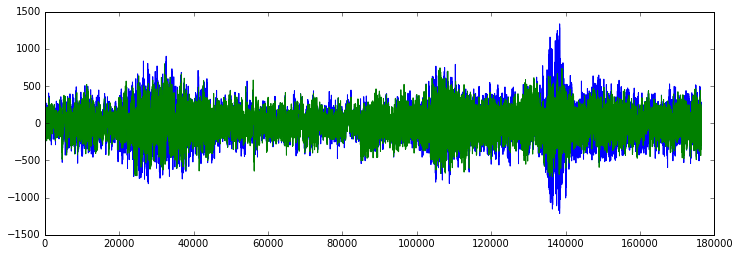

In [55]:
fullpath, label = path_class('100263-2-0-117.wav')
wav_plotter(fullpath,label)

I have briefly mentioned characteristics of the sound wave, but I still haven't looked at the concept of a digital audio signal. Without the understanding of digital signal, it is hard to understand what all these information means (sampling rate, bit depth, etc). So please allow me to take a detour to touch on basics of digital audio. Again if this is too elementary for you, feel free to skip.

An audio signal is a continuous analogue signal, and it is impossible for computers to process this type of continuous analogue data. It first needs to be transformed into the series of discrete values, and "sampling" is doing just that. "sampling rate" and "bit depth" is two of the most important elements when discretizing audio signal. In the below picture, you can see how they are related to analogue to digital conversion. In the graph, the x-axis is time, the y-axis is amplitude. "sampling rate" decides how frequent it will take samples, and "bit depth" decides how detailed it will take samples.

![title](urbansound_image/bit-depth-sample-rate-audio-interface.jpg)

Let's take CD as an example. Normally, CD has 44.1khz sampling rate with 16-bit depth. First, the sampling rate of 44.1khz tells us that samples are taken 44,100 times per second. 16 bit tells us that any sample can take a value from range 65,536 values corresponding to its amplitude. Compared to 8 bit, samples taken with 16 bit will be 256 times more detailed than that of 8 bit. By the way, if you are wondering why CD has a 44.1khz sampling rate, I recommend the same Youtube video I mentioned above. It will give you an intuitive understanding of sampling, aliasing, and Nyquist Theorem.
https://youtu.be/yWqrx08UeUs

| WAV format | # of possible values (per sample) | range |
|------|-----|-----------------------------------|-------|
|   32-bit PCM  | 4,294,967,296 | -2147483648 ~ +2147483647 |
|16-bit PCM | 65,536 | -32768 ~ +32767 |
| 8-bit PCM | 256 | 0 ~ 255 |

The number of channels tells us how many channels are there. We call it stereo when 2 channels are used, and call it mono when only one channel is used. Of course, mono sound can be played with more than one speaker, but it is still the exact same copy of the signal, which is played through the speakers. On the other hand, stereo is recorded with two different input channels of the same audio signal. What we normally see is stereo sound with left and right, this gives us a sense of directionality, perspective, space.

Now we have some of the important pieces of the puzzle to understand what the metadata of the WAVav file is telling us.

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  children_playing


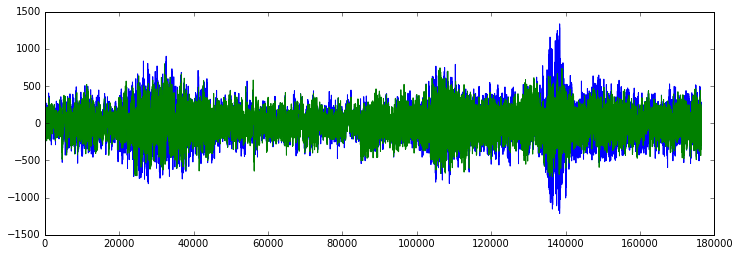

In [56]:
fullpath, label = path_class('100263-2-0-117.wav')
wav_plotter(fullpath,label)

The sampling rate is same as CD quality, 44.1khz, bit depth is as again CD quality. It is stereo sound, and we can also see that from the plot. The green colour is plotting one channel while blue is plotting the other. It is a 4-second clip. Since the sampling rate is 44.1khz and the duration is 4 seconds, we can easily calculate the number of samples in the data by multiplying 44100 by 4, which is 176,400.

But here's the bad news. By taking another look at the information on Urbansound8K, there's a note saying "8732 audio files of urban sounds (see description above) in WAV format. The sampling rate, bit depth, and number of channels are the same as those of the original file uploaded to Freesound (and hence may vary from file to file)."

Uh oh. It means there might be many different sample rates in the data, which means even with the same duration, the number of samples will be different. That doesn't sound good to build a model with. Moreover, different bit depth means, they can take different rage of values. Some of them might be stereo, while others are mono. That also doesn't sound good.

In the next post, I will continue with my journey on sound data preparion.